## Pontificia Universidad Javeriana

*Autores:*
- Diego Alejandro Jara Rojas  
- Juan Felipe González Quintero  
- Tomás Felipe Guerra Hernández  
- Isaías Acosta Herrera  

*Fecha de Inicio:* 10 - 10 - 2025  
*Fecha de Finalización:* 17 - 10 - 2025  

---

## **Proyecto**
*Análisis de los factores socioeconómicos y delictivos asociados a los arrestos en la ciudad de Nueva York mediante técnicas de procesamiento de Big Data.*

---

## **Problemática**
El aumento de arrestos en ciertos distritos de Nueva York plantea la necesidad de analizar qué factores pueden estar influyendo en esta tendencia.  
Mediante la integración de datos sobre pobreza, criminalidad en escuelas y registros de arrestos, se busca identificar patrones y correlaciones que permitan entender si la desigualdad socioeconómica y la violencia escolar tienen un impacto significativo en las tasas de arrestos.

---

## **Objetivo**
Realizar un análisis exploratorio y predictivo sobre los arrestos en Nueva York a partir de datos públicos de pobreza, crímenes en escuelas y reportes policiales, con el fin de determinar posibles relaciones entre las condiciones sociales y los niveles de criminalidad y detención.

---

## **Metodología**

1. *Importación de datos desde el cluster*  
   Carga de datasets en distintos formatos (CSV, Parquet) provenientes de fuentes oficiales del estado de Nueva York.  

2. *Preprocesamiento y limpieza de datos*  
   Estandarización de valores, manejo de nulos, combinación de bases de datos y normalización de variables.  

3. *Análisis exploratorio de datos (EDA)*  
   Cálculo de medidas estadísticas y visualización de distribuciones para identificar tendencias por distrito, tipo de crimen, nivel de pobreza y número de arrestos.  

4. *Modelado y correlación de variables*  
   Aplicación de modelos estadísticos y de aprendizaje automático (como regresión lineal y modelos de correlación múltiple) para evaluar relaciones entre pobreza, crimen y arrestos.  

5. *Evaluación e interpretación*  
   Análisis de resultados y visualización de patrones espaciales y sociales relevantes para comprender los factores más influyentes en la tasa de arrestos. (Ver documento)

6. *Fuentes de referencia*  
   - Open Data NYC  
   - Department of Education NYC  
   - NYPD Arrest Data Reports  
   - Artículos y estudios previos sobre desigualdad y criminalidad urbana.

# **1.Importación y configuración de recursos**

In [1]:
#Verificamos que estemos usando la versión de python instalada en nuestro cluster mediante conda
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [2]:
#Importación de todas las bibliotecas necesarias para procesamiento, gráficas y otros recursos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Bibliotecas especializadas
from pylab import *

In [3]:
import os

# Ajuste de las variables de entorno
os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
# Bibliotecas de Contexto PySpark, MLlib y contexto para levantar la sesión de PYSPARK

#Búsqueda de inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#Se crea una sesión para hacer el contexto de procesamiento desde mi Cuota de cluster HPC (No tenemos acceso a todos los cores, son compartidos)
from pyspark import SparkConf
##Se levanta la configuración de mi Cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

configura.setAppName("NY_Arrestos_Proyecto")

sparkSPA = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext = sparkSPA.sparkContext, sparkSession = sparkSPA)

contextoSparkSPA = sparkSPA.sparkContext.getOrCreate()

print("Sesión cluster Arrestos")

sparkSPA

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 23:14:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/21 23:14:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sesión cluster Arrestos


In [6]:
# Como estoy desde un servidor que no es mío y ni siquiera lo he implementado
# Requiero saber que configuración de hardware le han dado a mi cuota de sesión
# Adicional, requiero como hacer un cluster para saber la forma en la que se implementa

cantCPUS = sparkSPA._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPUS en mi cuota de sesión sparkSPA: {cantCPUS} ")
print(sparkSPA.sparkContext.getConf().getAll())

Cantidad de CPUS en mi cuota de sesión sparkSPA: 1 
[('spark.app.name', 'NY_Arrestos_Proyecto'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.d

# **2. Carga de datos desde el clúster**

In [7]:
#Especificamos la ruta donde está ubicado el archivo csv en el cuál vamos a basarnos para su procesamiento y análsis.
ruta = "/almacen/proyecto/NYPD_Arrests_Data__Historic__20251009.csv"

#Cargamos el archivo en forma de un dataframe con PySpark y mostramos los primeros 5 registros para verificar la carga correcta del archivo.
df00 = sparkSPA.read.csv(ruta, header=True, inferSchema=True)
df00.show(5)

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|  101|           ASSAULT 3|  344|ASSAULT 3 & RELAT...|PL 1200001|         M|          K|             73|                0|    25-44|       M|               BLACK|   1012087

# **3. Análisis y Preparación de Datos**

Se presentan datos (csv) con los diferentes parámetros asociados a las detenciones realizadas en la ciudad de Nueva York. En esta sección se realiza una exploración de las variables que componen este conjunto de datos a través de la descripción de:

- **Tipo de datos:** coherencia de tipo de datos, transformación, etc.
- **Columnas:** conocimiento de columnas, eliminación.
- **Análisis de datos nulos o imposibles:** conocimiento.

In [8]:
#Conocimiento de las columnas
df00.columns

['ARREST_KEY',
 'ARREST_DATE',
 'PD_CD',
 'PD_DESC',
 'KY_CD',
 'OFNS_DESC',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'Lon_Lat']

Las columnas más importantes para este estudio son las siguientes:

- **ARREST_KEY:** Llave única generada aleatoriamente para identificar cada arresto.
- **ARREST_DATE:** Fecha exacta del arresto.
- **LAW_CODE:** Cargos acordes al código penal del Estado de Nueva York de los cuáles se acusa al arrestado.
- **LAW_CAT_CD:** Nivel del delito: delito grave, delito menor o infracción.
- **ARREST_BORO:** Distrito donde se produjo la detención: B (Bronx), S (Staten Island), K (Brooklyn), M (Manhattan), Q (Queens).
- **ARREST_PRECINCT:** Distrito policial donde se realizó la detención.
- **AGE_GROUP:** Categoría de edad del perpetrador.
- **PERP_SEX:** Descripción del sexo del perpetrador.
- **PERP_RACE:** Descripción de la raza a la que pertenece el perpetrador.
- **X_COORD_CD:** Coordenada X de mitad de bloque para el sistema de coordenadas del estado de Nueva York, zona de Long Island, NAD 83, unidades en pies (FIPS 3104)
- **Y_COORD_CD:** Coordenada Y de mitad de bloque para el sistema de coordenadas del estado de Nueva York, zona de Long Island, NAD 83, unidades en pies (FIPS 3104)
- **Latitude:** Latitud representada en el Sistema Global de Coordenadas en Grados Decimales.
- **Longitude:** Longitud representada en el Sistema Global de Coordenadas en Grados Decimales.
- **Lon_Lat:** Columna de puntos georreferenciados basada en los campos de longitud y latitud.

In [9]:
#Se procede a identificar los tipos de datos originales del conjunto de datos de Arrestos
df00.dtypes

[('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('PD_CD', 'int'),
 ('PD_DESC', 'string'),
 ('KY_CD', 'int'),
 ('OFNS_DESC', 'string'),
 ('LAW_CODE', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'int'),
 ('JURISDICTION_CODE', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Lon_Lat', 'string')]

Como se puede evidenciar, **no existen variables en este conjunto de datos a las que sea necesario aplicarles una transformación en primera instancia**, con lo que este paso **será omitido**. Sin embargo, más adelante se realizarán procesos de estandarización de algunas variables para que estas coincidan y puedan relacionarse de mejor forma con los otros conjuntos de datos utilizados en este estudio (Pobreza e Incidentes en escuelas de Nueva York).

In [10]:
#Se hace una descripción estadísitca de los parámetros/variables del conjunto de datos para una exploración inicial
for valor in df00.columns:
  df00.describe([valor]).show()

+-------+--------------------+
|summary|          ARREST_KEY|
+-------+--------------------+
|  count|              246773|
|   mean|1.8273193780121407E8|
| stddev|  5920200.7362956125|
|    min|           173129257|
|    max|           191719213|
+-------+--------------------+



+-------+-----------+
|summary|ARREST_DATE|
+-------+-----------+
|  count|     246773|
|   mean|       NULL|
| stddev|       NULL|
|    min| 01/01/2018|
|    max| 12/31/2018|
+-------+-----------+

+-------+------------------+
|summary|             PD_CD|
+-------+------------------+
|  count|            246704|
|   mean|467.85989282703156|
| stddev| 279.4868938180626|
|    min|                 0|
|    max|               997|
+-------+------------------+



+-------+--------------------+
|summary|             PD_DESC|
+-------+--------------------+
|  count|              245848|
|   mean|                NULL|
| stddev|                NULL|
|    min|A.B.C.,FALSE PROO...|
|    max|WEAPONS,PROHIBITE...|
+-------+--------------------+

+-------+-----------------+
|summary|            KY_CD|
+-------+-----------------+
|  count|           245848|
|   mean|268.2900328658358|
| stddev|151.0865849908115|
|    min|              101|
|    max|              995|
+-------+-----------------+

+-------+--------------------+
|summary|           OFNS_DESC|
+-------+--------------------+
|  count|              245848|
|   mean|                NULL|
| stddev|                NULL|
|    min|            ABORTION|
|    max|VEHICLE AND TRAFF...|
+-------+--------------------+

+-------+----------+
|summary|  LAW_CODE|
+-------+----------+
|  count|    246728|
|   mean|      NULL|
| stddev|      NULL|
|    min|ABC00000MA|
|    max|VTL125100A|
+-------+----------

## **Exploración de valores nulos en los datos**

En esta sección usamos diferentes consultas para **revisar si en el conjunto de datos existen datos nulos o con valores imposibles** para poder realizar su limpieza, ya de no realizarse, podría verse afectada la generación de visualizaciones gráficas y las conclusiones a sacar de este estudio.

In [11]:
#Rastreamos la cantidad de valores nulos o imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

[Stage 60:==============>                                           (1 + 3) / 4]

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+-------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lon_Lat|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+-------+
|         0|          0|   69|    925|  925|      925|      45|      1695|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|      0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+-------+



Con esto se comprueba que **efectivamente existen varias columnas con datos nulos** por lo que para generar un dataframe para realizar las visualizaciones del conjunto de datos, **conservaremos únicamente** los datos sin estos registros (más adelante se eliminarán varias de las columnas que tienen datos nulos ya que no poseen información útil para el estudio)

# **4. Eliminación de columnas no relevantes**


Para este estudio se contempla hacer uso de algunas de las columnas del conjunto de datos de arrestos, por lo que se procede a eliminar aquellas que no representan información importante.

In [12]:
#Eliminamos las columnas que no son relevantes para el estudio
df01 = df00.drop('PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CAT_CD', 'JURISDICTION_CODE')
#Mostramos las primeras 10 filas para verificar que los cambios hayan sido aplicados
df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|PL 1200001|          K|             73|    25-44|       M|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|
| 191698305| 12/31/2018|VTL05110A4|          S|            123|    25-44|       M|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|
| 191680846| 12/31/2018|PL 1200001|          Q|            102|    25-44|  

Las columnas seleccionadas para continuar con el estudio se justifican a continuación:

- **ARREST_KEY y ARREST_DATE:** Permiten identificar cada detención realizada a través de una clave combinada única.
- **LAW_CODE y LAW_CAT_CD:** Permite identificar con mayor detalle el carácter de la ley quebrantada y justificar la detención.
- **ARREST_BORO y ARREST_PRECINCT:** Permiten ubicar geográficamente el arresto y además, relacionar por medio del distrito la información de este conjunto de datos con la que se presenta en los demás conjuntos utilizados para este estudio.
- **AGE_GROUP, PERP_SEX y PERP_RACE:** Reflejan parte de las características clave del perpetrador con mayor detalle. Esto permite construir arquetipos de persona para realizar un mejor análisis sobre los datos.
- **X_COORD_CD, Y_COORD_CD, Longitude, Latitude y Lon_Lat:** Debido a la naturaleza de este estudio basada en las zonas geográficas de Nueva York para relacionar los conjuntos de datos, las coordenadas, longitud y latitud de cada detención representan información importante para el análisis.

Una vez seleccionadas las columnas, **volvemos a explorar la cantidad de valores nulos** ya que, como se mencionó antes, la mayor parte de los valores nulos se encontraban en columnas que no son relevantes para los fines de este estudio

In [13]:
#Se vuelve a hacer el conteo de valores nulos para verificar que no queden valores sin tratar
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

[Stage 64:=============================>                            (2 + 2) / 4]

+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+
|ARREST_KEY|ARREST_DATE|LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lon_Lat|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+
|         0|          0|      45|          0|              0|        0|       0|        0|         0|         0|       0|        0|      0|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+



# **5. Estandarización de variables**

Como se mencionó anteriormente, para efectos prácticos de este estudio se realiza un proceso de estandarización de variables, por medio del cuál se unifican los tipos de variable y convenciones para las variables coincidentes entre los diferentes conjuntos de datos. Los cambios a aplicar se listan a continuación:

1. **Borough:** La variable que se encuentra en los 3 conjuntos de datos es el borough, sin embargo, todos siguen un estandar diferente. Se decidió tomar como estandar principal la categorización por medio de números:
   [1 Bronx | 2 Brooklyn | 3 Manhattan | 4 Queens | 5 Staten Island\].
2. **Sexo:** Se encuentra en el conjunto de datos de pobreza y en el de arrestos.
   Para estandarizarla se decidió hacerlo con los números: [1 Hombre | 2 Mujer\].
4. **Categoría de edades:** Al encontrarse en esta y en la base de datos de arrestos, para estandarizar, se decidió tomar los rangos descritos en la base de datos de arrestos, para formar una columna de categoria edad usando la columna AGEP.
    [1 Menor de 18 años | 2 De 18 a 24 años | 3 25 a 44 años| 4 45 a 64 años | 5 65+ años \].

### **Estandarización de ARREST_BORO**

In [14]:
#Importación de recursos extra de pyspark
from pyspark.sql.functions import when, col

#Se asignan los reemplazos de cada uno de los valores de la columna "ARREST_BORO" para que estos coincidan con los de los demás datasets
df01 = (
    df01.withColumn(
        "ARREST_BORO",
        when(col("ARREST_BORO") == "B", 1)
        .when(col("ARREST_BORO") == "K", 2)
        .when(col("ARREST_BORO") == "M", 3)
        .when(col("ARREST_BORO") == "Q", 4)
        .when(col("ARREST_BORO") == "S", 5)
        .otherwise(None)  
    )
)

#Verificamos que los cambios hayan sido aplicados al dataframe
df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|PL 1200001|          2|             73|    25-44|       M|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|
| 191698305| 12/31/2018|VTL05110A4|          5|            123|    25-44|       M|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|
| 191680846| 12/31/2018|PL 1200001|          4|            102|    25-44|  

### **Estandarización de PERP_SEX**

In [15]:
#Se asignan los reemplazos de cada uno de los valores de la columna "PERP_SEX" para que estos coincidan con los de los demás datasets
df01 = (
    df01.withColumn(
        "PERP_SEX",
        when(col("PERP_SEX") == "M", 1)
        .when(col("PERP_SEX") == "F", 2)
        .otherwise(None)  
    )
)

#Verificamos que los cambios hayan sido aplicados al dataframe
df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|PL 1200001|          2|             73|    25-44|       1|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|
| 191698305| 12/31/2018|VTL05110A4|          5|            123|    25-44|       1|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|
| 191680846| 12/31/2018|PL 1200001|          4|            102|    25-44|  

### **Estandarización de AGE_GROUP y Creación de AgeCategory**

In [16]:
#Se crea una nueva columna llamada "AgeCategory" donde se usará como referencia la columan "AGE_GROUP" para asignar categorías numéricas a las edades
# y así que puedan relacionarse con la información de los otros conjuntos de datos utilizados en el estudio

df01 = (
    df01.withColumn(
        "AgeCategory",
        when(col("AGE_GROUP").rlike("<18"), 1)  # Menor de 18
        .when(col("AGE_GROUP").isin("18-24"), 2)
        .when(col("AGE_GROUP").isin("25-44"), 3)
        .when(col("AGE_GROUP").isin("45-64"), 4)
        .when(col("AGE_GROUP").rlike("65|65\\+|65 y más|65 or older"), 5)
        .otherwise(None)
    )
)

df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+-----------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|AgeCategory|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+-----------+
| 191678717| 12/31/2018|PL 1200001|          2|             73|    25-44|       1|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|          3|
| 191698305| 12/31/2018|VTL05110A4|          5|            123|    25-44|       1|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|          3|
| 191680846| 12

In [17]:
#Verificamos los tipos de datos una vez más para visualizar los cambios aplicados por medio de estandarización y el tipo de la nueva columna
df01.dtypes

[('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('LAW_CODE', 'string'),
 ('ARREST_BORO', 'int'),
 ('ARREST_PRECINCT', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'int'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Lon_Lat', 'string'),
 ('AgeCategory', 'int')]

## **Tratamiento de datos nulos**
Con el objetivo de que no existan datos nulos que puedan afectar en el proceso de graficación y análisis, se decide darle tratamiento a los datos nulos de las columnas que las tienen.
Para este caso, reemplazamos por el valor 'NA' las cadenas nulas que hay en la columna que aún conserva datos nulos.

In [18]:
# Se reemplaza todos los valores nulos o NaN por 0
df01 = df01.fillna({'LAW_CODE': 'NA'})


# Confirmar que se reemplazaron correctamente
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

[Stage 70:==============>                                           (1 + 3) / 4]

+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+-----------+
|ARREST_KEY|ARREST_DATE|LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lon_Lat|AgeCategory|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+-----------+
|         0|          0|       0|          0|              0|        0|       0|        0|         0|         0|       0|        0|      0|          0|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+-----------+



# **6. Visualización gráfica de datos**

En esta sección, con el fin de explorar los conjuntos de datos de forma más detallada y hallar correlaciones entre las variables que lo componen, se procede a realizar diferentes visualizaciones de algunas de las correlaciones encontradas.

## **Gráfica de Top 10 códigos de ley quebrantados por distrito en diferentes grupos de edad**

In [19]:
from pyspark.sql import functions as F

# Se crea un dataframe para graficar en el que se agrupa por las variables que van a ser utilizadas
df_grafica = (
    df01.groupBy("ARREST_BORO", "AgeCategory", "LAW_CODE")
        .agg(F.count("*").alias("TotalArrests"))
)


In [20]:
# Converitmos el dataframe de pyspark a pandas para generar las visualizaciones
df_pandas = df_grafica.toPandas()

In [21]:
#Se hace un mapeo de los distritos para las gráficas
boro_map = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Creamos una nueva columna solo para la visualización
df_pandas["Borough"] = df_pandas["ARREST_BORO"].map(boro_map)


In [22]:
top_n = 10  #Número de códigos de arrestos a buscar

# Contar total de arrestos por distrito y código de ley
df_top = (
    df_pandas.groupby(["Borough", "LAW_CODE"])["TotalArrests"]
    .sum()
    .reset_index()
)

# Tomar los N más altos por distrito
df_top = (
    df_top.sort_values(["Borough", "TotalArrests"], ascending=[True, False])
          .groupby("Borough")
          .head(top_n)
)

# Combinar con las categorías de edad para graficar correctamente
df_plot = df_pandas.merge(df_top[["Borough", "LAW_CODE"]], on=["Borough", "LAW_CODE"])

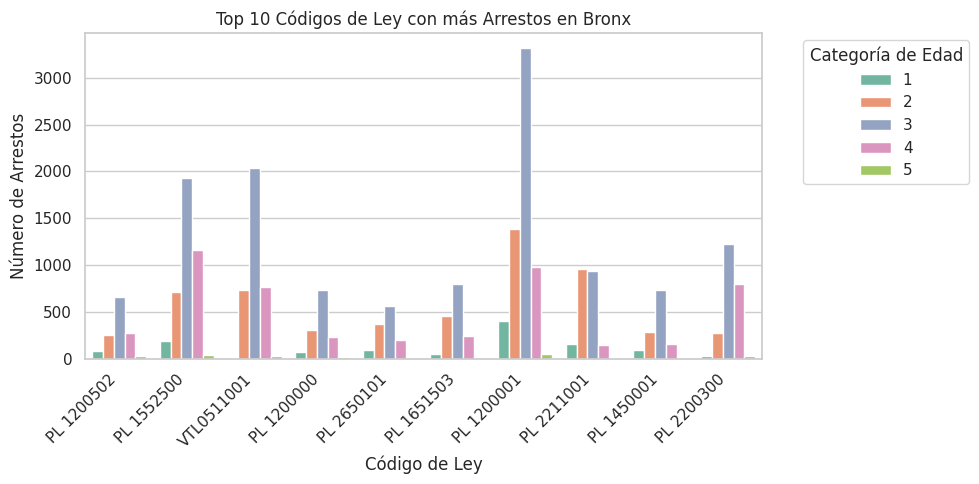

✅ Gráfica guardada: /almacen/proyecto/graficas_proyecto/grafica_Bronx_arrestos.png


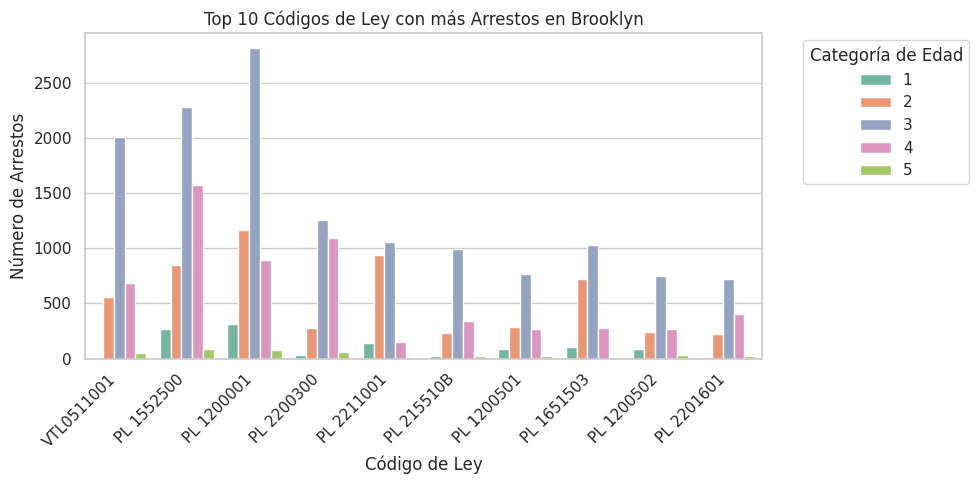

✅ Gráfica guardada: /almacen/proyecto/graficas_proyecto/grafica_Brooklyn_arrestos.png


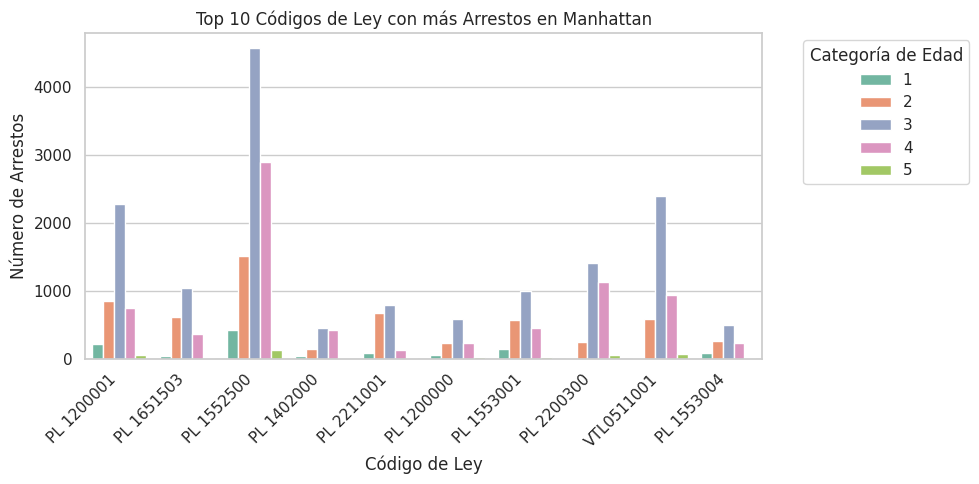

✅ Gráfica guardada: /almacen/proyecto/graficas_proyecto/grafica_Manhattan_arrestos.png


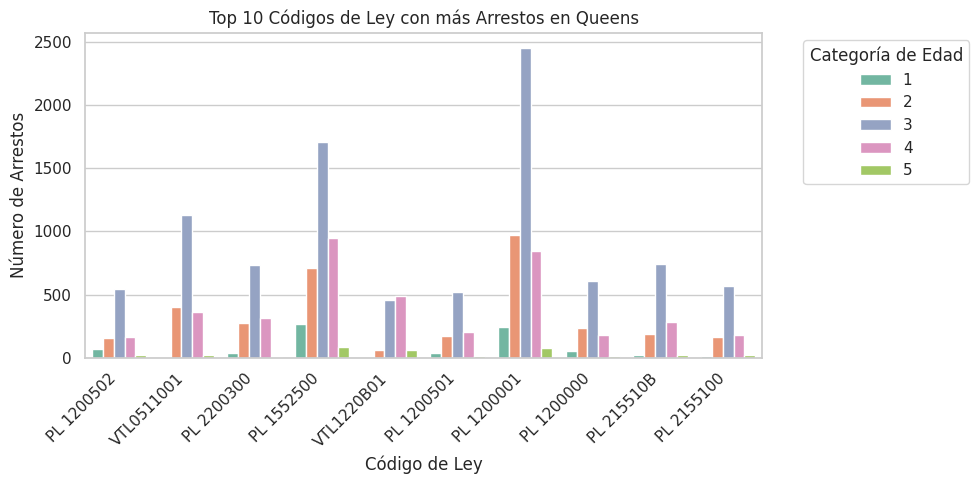

✅ Gráfica guardada: /almacen/proyecto/graficas_proyecto/grafica_Queens_arrestos.png


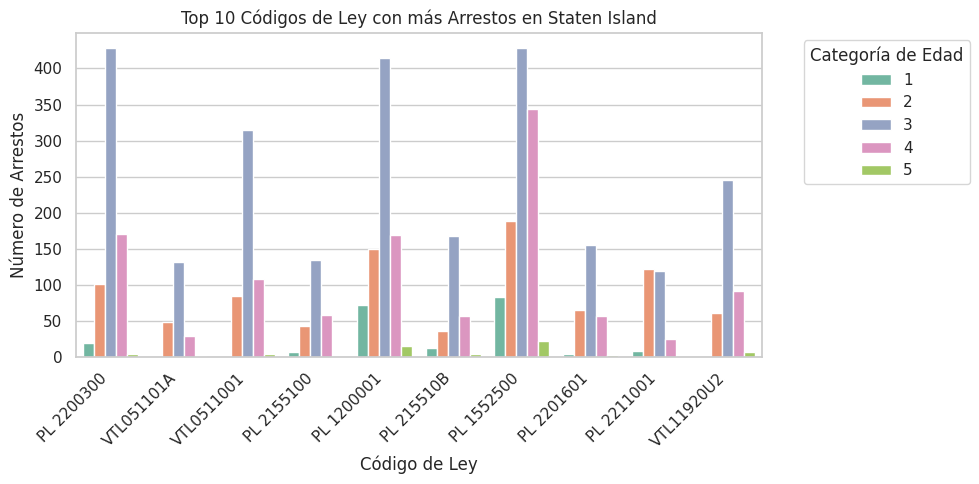

✅ Gráfica guardada: /almacen/proyecto/graficas_proyecto/grafica_Staten_Island_arrestos.png

🎉 Todas las gráficas fueron exportadas correctamente.


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Se define la ruta de guardado para exportar las gráficas al cluster
ruta_guardado = '/almacen/proyecto/graficas_proyecto'
os.makedirs(ruta_guardado, exist_ok=True)

sns.set(style="whitegrid")

for boro, data in df_plot.groupby("Borough"):
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=data,
        x="LAW_CODE",
        y="TotalArrests",
        hue="AgeCategory",
        palette="Set2"
    )
    plt.title(f"Top {top_n} Códigos de Ley con más Arrestos en {boro}")
    plt.xlabel("Código de Ley")
    plt.ylabel("Número de Arrestos")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Categoría de Edad", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.show()
        # Guardar la gráfica en archivo PNG
    nombre_archivo = f"grafica_{boro.replace(' ', '_')}_arrestos.png"
    ruta_completa = os.path.join(ruta_guardado, nombre_archivo)
    plt.savefig(ruta_completa, dpi=300)
    plt.close()  # Cierra la figura para liberar memoria
    
    print(f"✅ Gráfica guardada: {ruta_completa}")

   

print("\n🎉 Todas las gráficas fueron exportadas correctamente.")

## **Gráfica de número de crímenes por raza en cada distrito de NY**

In [24]:
from pyspark.sql import functions as F

# Agrupar por distrito (ARREST_BORO) y raza (PERP_RACE)
df_race_boro = (
    df01.groupBy("ARREST_BORO", "PERP_RACE")
        .agg(F.count("*").alias("TotalArrests"))
        .orderBy("ARREST_BORO")
)


In [25]:
# Converitmos el dataframe de pyspark a pandas para generar las visualizaciones
df_race_boro_pd = df_race_boro.toPandas()

In [26]:
#Se hace un mapeo de los distritos para las gráficas
borough_names = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Crear una columna temporal solo para los nombres legibles en la gráfica
df_race_boro_pd["BoroughName"] = df_race_boro_pd["ARREST_BORO"].map(borough_names)


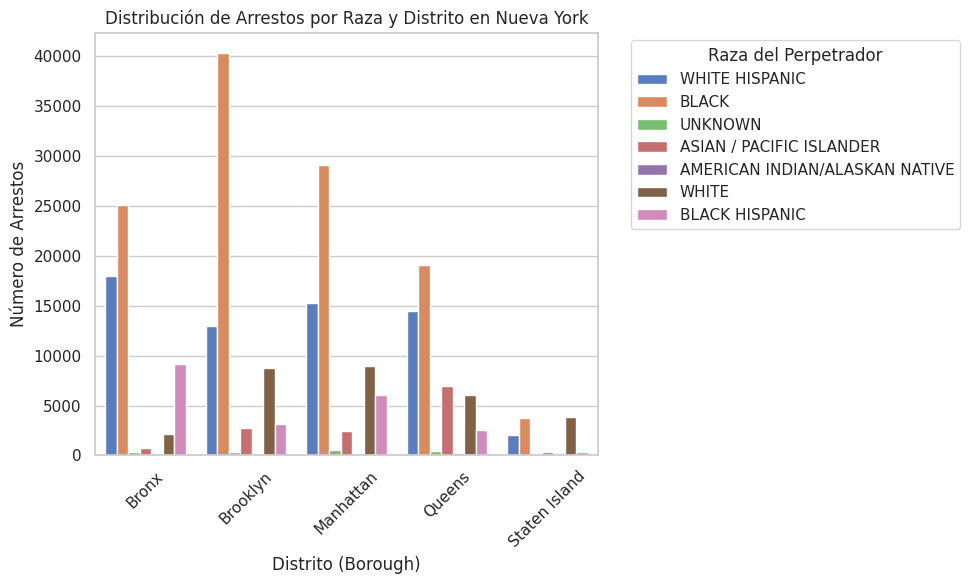

✅ Gráfica guardada en: /almacen/proyecto/graficas_proyecto/grafica_arrestos_por_raza.png


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted")

#Se genera la visualización
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_race_boro_pd,
    x="BoroughName",
    y="TotalArrests",
    hue="PERP_RACE"
)

plt.title("Distribución de Arrestos por Raza y Distrito en Nueva York")
plt.xlabel("Distrito (Borough)")
plt.ylabel("Número de Arrestos")
plt.xticks(rotation=45)
plt.legend(title="Raza del Perpetrador", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

ruta_guardado = '/almacen/proyecto/graficas_proyecto/grafica_arrestos_por_raza.png'
plt.savefig(ruta_guardado, dpi=300)
plt.close()

print(f"✅ Gráfica guardada en: {ruta_guardado}")


### **Gráfica de arrestos por distrito**

/tmp/ipykernel_288032/3288321814.py:94: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  nyc_boroughs_3857.boundary.plot(ax=ax, color="gray", linewidth=0.6, alpha=0.7, zorder=3)


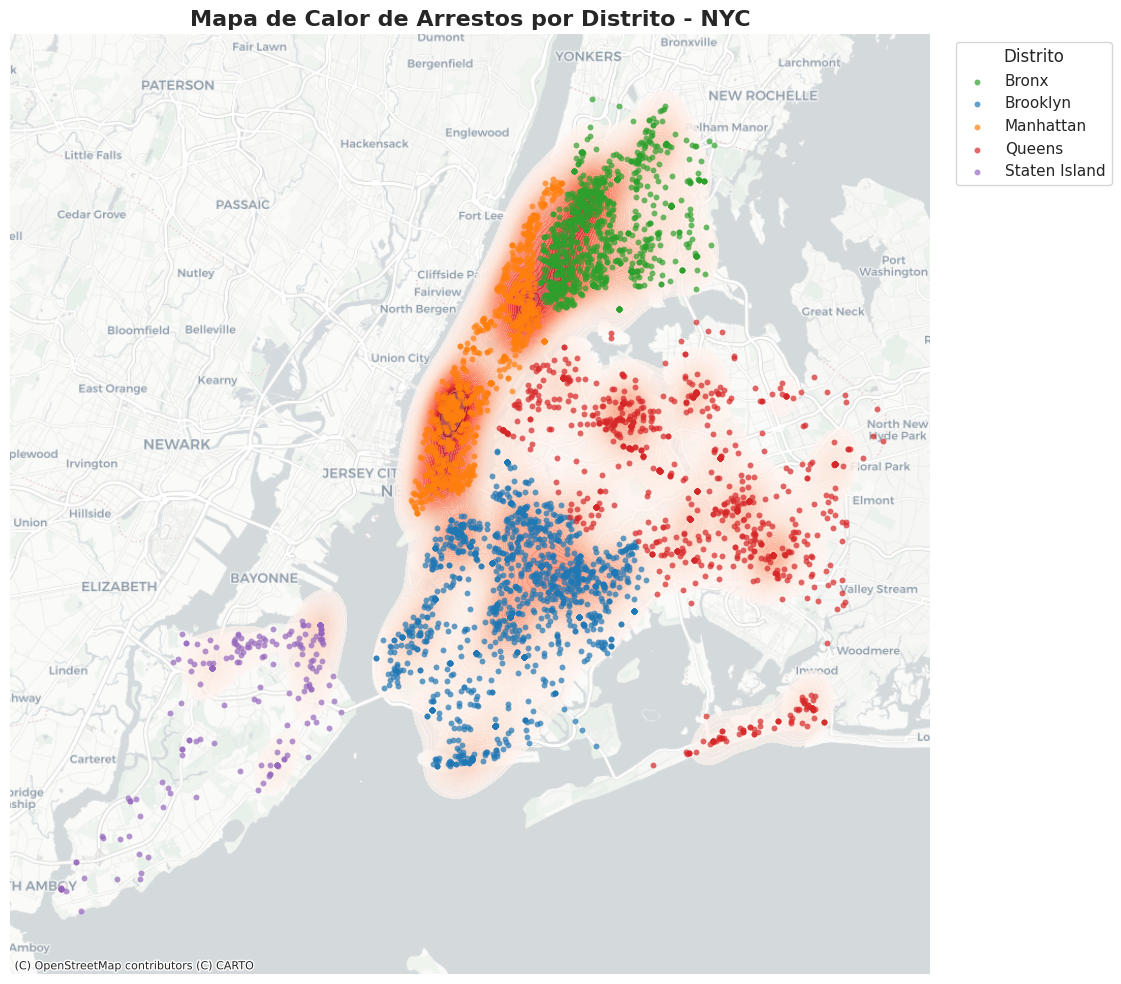

✅ Mapa guardado en: /almacen/proyecto/graficas_proyecto/mapa_calor_arrestos.png


In [28]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import numpy as np
import os

# ------------------------
# Rutas y opciones
# ------------------------
shapefile_path = "/almacen/proyecto/archivos_mapas/geo_export_10e83475-8cb8-400e-9abf-4624791afdb9.shp"
ruta_salida = "/almacen/proyecto/graficas_proyecto"
os.makedirs(ruta_salida, exist_ok=True)
ruta_imagen = os.path.join(ruta_salida, "mapa_calor_arrestos.png")

# ------------------------
# 1) Cargar shapefile y poner en EPSG:4326 (si no lo está)
# ------------------------
nyc_boroughs = gpd.read_file(shapefile_path)
nyc_boroughs = nyc_boroughs.to_crs(epsg=4326)  # lat/lon

# ------------------------
# 2) Cargar y limpiar datos de arrestos desde PySpark -> pandas
# ------------------------
# Selecciona columnas necesarias y quita nulos
df_pd = df01.select("ARREST_BORO", "Latitude", "Longitude").dropna().toPandas()

# Eliminar filas con lat/lon no numéricas o infinitas
df_pd = df_pd[np.isfinite(df_pd['Latitude']) & np.isfinite(df_pd['Longitude'])]

# Filtrar fuera de los límites razonables de NYC (opcional, evita puntos erróneos)
df_pd = df_pd[(df_pd['Latitude'] > 40.4) & (df_pd['Latitude'] < 41.0) &
              (df_pd['Longitude'] > -74.3) & (df_pd['Longitude'] < -73.65)]

# Mapear nombres de borough (sólo para colores/leyenda)
borough_names = {1:"Bronx",2:"Brooklyn",3:"Manhattan",4:"Queens",5:"Staten Island"}
df_pd["Borough"] = df_pd["ARREST_BORO"].map(borough_names)

# Si no hay datos, salir con aviso
if df_pd.shape[0] == 0:
    raise RuntimeError("No hay puntos válidos tras limpiar lat/lon. Revisa el filtro.")

# ------------------------
# 3) Crear GeoDataFrame y proyectar a WebMercator (EPSG:3857) para el basemap
# ------------------------
gdf_arrestos = gpd.GeoDataFrame(
    df_pd,
    geometry=gpd.points_from_xy(df_pd.Longitude, df_pd.Latitude),
    crs="EPSG:4326"
)

# proyectar ambos GeoDataFrames a 3857 (metros) para contextily
gdf_arrestos_3857 = gdf_arrestos.to_crs(epsg=3857)
nyc_boroughs_3857  = nyc_boroughs.to_crs(epsg=3857)

# ------------------------
# 4) Preparar figura y ejes (un solo ax)
# ------------------------
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 10))

# ------------------------
# 5) Dibujar el KDE (mapa de calor) usando coordenadas proyectadas (x, y arrays)
# ------------------------
# seaborn.kdeplot acepta x,y como arrays; usamos arrays en metros (EPSG:3857)
x = gdf_arrestos_3857.geometry.x.values
y = gdf_arrestos_3857.geometry.y.values

# Para datasets muy grandes, puedes muestrear para el KDE (opcional)
kde_frac = 1.0  # poner 0.1 para muestrear 10%
if kde_frac < 1.0:
    idx = np.random.choice(len(x), int(len(x)*kde_frac), replace=False)
    x_kde, y_kde = x[idx], y[idx]
else:
    x_kde, y_kde = x, y

sns.kdeplot(
    x=x_kde,
    y=y_kde,
    fill=True,
    cmap="Reds",
    alpha=0.7,
    thresh=0.05,
    levels=50,
    bw_method="scott",  # o ajusta con bw_adjust si necesitas mayor/suave resolución
    zorder=1,
    ax=ax
)

# ------------------------
# 6) Dibujar polígonos de boroughs (límites) en gris sutil
# ------------------------
nyc_boroughs_3857.boundary.plot(ax=ax, color="gray", linewidth=0.6, alpha=0.7, zorder=3)

# ------------------------
# 7) Dibujar puntos muestreados por borough, con colores distinguibles
# ------------------------
# Muestra pequeña para no saturar el plot
sample_frac = 0.02
gdf_sample = gdf_arrestos_3857.sample(frac=sample_frac, random_state=42)

# Crear paleta por borough
unique_boros = gdf_sample['Borough'].unique()
palette = dict(zip(unique_boros, sns.color_palette("tab10", len(unique_boros))))

# Dibujar con ax.scatter para tener control del edgecolor
for boro, sub in gdf_sample.groupby("Borough"):
    ax.scatter(
        sub.geometry.x,
        sub.geometry.y,
        s=18,
        c=[palette[boro]],
        label=boro,
        alpha=0.7,
        edgecolors=None,
        linewidths=0,
        zorder=4
    )

# ------------------------
# 8) Añadir basemap (contextily) — requiere que los ejes estén en EPSG:3857
# ------------------------
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# ------------------------
# 9) Ajustes finales y guardar
# ------------------------
ax.set_axis_off()  # opcional: quita los ejes para estilo mapa
ax.set_title("Mapa de Calor de Arrestos por Distrito - NYC", fontsize=16, weight="bold")
ax.legend(title="Distrito", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(ruta_imagen, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Mapa guardado en:", ruta_imagen)